In [39]:
import pandas as pd
import numpy as np
from pandas import Series
import matplotlib.pyplot as plt
import pickle
from urllib.request import urlopen
from urllib.parse import quote
from rdkit.Chem import MACCSkeys
from rdkit import Chem


In [2]:
# Dataset
ddi_dbank_df = pd.read_csv('https://raw.githubusercontent.com/dbmi-pitt/public-PDDI-analysis/master/PDDI-Datasets/DrugBank/drugbank5-interactions-NLM-R01-drugs.tsv',
                           sep='\t', header=0, names=['drug1', 'db_no1', 'drug2', 'db_no2', 'interaction', 'general_syntax'])


In [58]:
li = ['the risk or severity of adverse effects can be increased when drug1 is combined with drug2.',
      'the risk or severity of adverse effects can be increased when drug2 is combined with drug1.',
      'the serum concentration of drug1 can be increased when it is combined with drug2.',
      'the metabolism of drug2 can be decreased when combined with drug1.',
      'the serum concentration of drug2 can be increased when it is combined with drug1.',
      'the metabolism of drug1 can be decreased when combined with drug2.',
      'drug1 may increase the qtc-prolonging activities of drug2.',
      'drug2 may increase the qtc-prolonging activities of drug1.',
      'drug2 may increase the serotonergic activities of drug1.',
      'drug2 may increase the central nervous system depressant (cns depressant) activities of drug1.'
      ]


In [19]:
ddi_dbank_df[ddi_dbank_df['general_syntax'].isin(li)]
mp = {}
for i in ddi_dbank_df.index:
    general_syntax = ddi_dbank_df.at[i, 'general_syntax']
    if(general_syntax in li):
        if(general_syntax in mp):
            mp[general_syntax] += 1
        else:
            mp[general_syntax] = 1


In [31]:
sorted_list = list(reversed(sorted(mp.items(), key=lambda item: item[1])))
sorted_list


[('the risk or severity of adverse effects can be increased when drug1 is combined with drug2.',
  7398),
 ('the risk or severity of adverse effects can be increased when drug2 is combined with drug1.',
  6994),
 ('the serum concentration of drug1 can be increased when it is combined with drug2.',
  4634),
 ('the metabolism of drug2 can be decreased when combined with drug1.', 3978),
 ('the serum concentration of drug2 can be increased when it is combined with drug1.',
  3699),
 ('the metabolism of drug1 can be decreased when combined with drug2.', 2698),
 ('drug1 may increase the qtc-prolonging activities of drug2.', 1251),
 ('drug2 may increase the qtc-prolonging activities of drug1.', 1251),
 ('drug2 may increase the serotonergic activities of drug1.', 1014),
 ('drug2 may increase the central nervous system depressant (cns depressant) activities of drug1.',
  1000)]

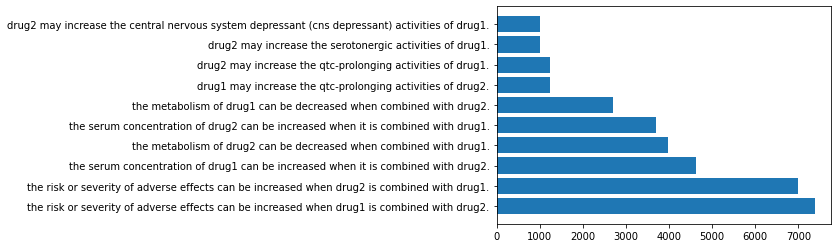

In [34]:
ind = []
fre = []
for item in sorted_list:
    ind.append(item[0])
    fre.append(item[1])

# plt.bar(ind, fre)
plt.barh(ind, fre)
plt.show()


# Validation of novel interactions

In [50]:
model = pickle.load(open('../models/poly_svc_model4.sav', 'rb'))


In [51]:
def smile_convert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + \
            quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'


def smiles_to_maccs(smile):
    mol = Chem.MolFromSmiles(smile)
    return MACCSkeys.GenMACCSKeys(mol).ToBitString()


def maccs_to_feature(maccs1, maccs2):
    fingerprint1 = maccs1
    fingerprint2 = maccs2
    # print(len(fingerprint1))
    result = ''
    for x in range(0, 167):
        if fingerprint1[x] == '0' and fingerprint2[x] == '0':
            result += '0'
        if fingerprint1[x] == '0' and fingerprint2[x] == '1':
            result += '2'
        if fingerprint1[x] == '1' and fingerprint2[x] == '0':
            result += '1'
        if fingerprint1[x] == '1' and fingerprint2[x] == '1':
            result += '3'
    return result


def string_to_numpy(s):
    combined_fingerprint = s
    # adding commas
    x = list(np.array(list(map(list, [combined_fingerprint]))))
    x = list(x[0])  # take array & not array of arrays of chars
    x = list(map(int, x))  # chars -> int
    return x


In [76]:
def check_interaction(drug1, drug2):
    smile1 = smile_convert(drug1)
    smile2 = smile_convert(drug2)
    maccs1 = smiles_to_maccs(smile1)
    maccs2 = smiles_to_maccs(smile2)
    unique_fprint = maccs_to_feature(maccs1, maccs2)
    unique_fprint = string_to_numpy(unique_fprint)
    # print(unique_fprint)
    pred = model.predict([unique_fprint])
    interaction = str(li[pred[0]])
    interaction = interaction.replace('drug1', drug1)
    interaction = interaction.replace('drug2', drug2)
    return interaction


# 10 dangerous novel interactions 

In [83]:
# 1.ACE Inhibitors-Potassium Acetates
check_interaction('benazepril', 'potassium acetate')
# Drugbank - The risk or severity of hyperkalemia can
#  be increased when Potassium acetate is combined with Benazepril.

'the risk or severity of adverse effects can be increased when potassium acetate is combined with benazepril.'

In [89]:
# 2.ACE Inhibitors-Spironolactone
check_interaction('benazepril', 'amiodarone')
# Drugbank - As both potassium-sparing diuretics and ACE inhibitors
#  have the potential to elevate serum potassium levels, 

'the serum concentration of benazepril can be increased when it is combined with amiodarone.'

In [90]:
# 3.digoxin-verapamil
check_interaction('digoxin', 'verapamil')
# Drugbank - The serum concentration of Digoxin can be 
# increased when it is combined with Verapamil.

'the serum concentration of digoxin can be increased when it is combined with verapamil.'

In [95]:
# 4.Theophylline-Quinolones
check_interaction('Barazan', 'Theophylline')
# Drugbank - leading to elevated serum xanthine/xanthine derivative levels

'the serum concentration of Theophylline can be increased when it is combined with Barazan.'

In [105]:
# 5.Cimetidine and metformin
check_interaction('Cimetidine', 'Metformin')
# Drugbank -  increase the serum concentrations of metformin, which may result in an elevated
#  risk for developing metformin-related adverse events,

[00:53:30] WARNING: not removing hydrogen atom without neighbors


'the risk or severity of adverse effects can be increased when Metformin is combined with Cimetidine.'

In [101]:
# 6.Bismuth plus furosemide
check_interaction('Bismuth', 'Furosemide')
# Drugbank - The risk or severity of adverse effects can be increased when 
# Furosemide is combined with Bismuth subsalicylate.

'the risk or severity of adverse effects can be increased when Furosemide is combined with Bismuth.'

In [103]:
# 7.NSAIDs and thiazide diuretics
check_interaction('Hydrochlorothiazide', 'Diclofenac')
# Drugbank - leading to increased serum concentrations of OAT3 substrates

'the serum concentration of Hydrochlorothiazide can be increased when it is combined with Diclofenac.'

In [82]:
# 8.Warfarin-NSAIDs
check_interaction('warfarin', 'diclofenac')
# Drugbank - may also interfere with the metabolism of S-warfarin 
# and further increase the risk for warfarin-associated bleeding.

'the metabolism of warfarin can be decreased when combined with diclofenac.'

In [80]:
# 9.Warfarin-Quinolones 
check_interaction('warfarin', 'ciprofloxacin')

# Drugbank - The serum concentration of Warfarin can be increased 
# when it is combined with Ciprofloxacin.

'the serum concentration of warfarin can be increased when it is combined with ciprofloxacin.'

In [78]:
# 10.Warfarin-Sulfa 
check_interaction('warfarin', 'sulfamethizole')

# Drugbank -  This interaction may be significant as the affected drug has a narrow therapeutic index, therefore any increase in the serum concentration of this drug may have drastic effects on the tolerability of the medication 
# and a significant increase in incidence or severity of adverse effects.

'the risk or severity of adverse effects can be increased when warfarin is combined with sulfamethizole.'